Import Packages

In [ ]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from hyperopt import hp
from sklearn.metrics import log_loss
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
import shap
import pickle


Data Read

In [108]:
df = pd.read_csv("./data/credit.csv", index_col=0)
df.shape

(1000, 22)

In [109]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job,gender
0,-43.0,6,critical,radio/tv,1169,NaN,13 years,4,single,none,...,67,none,own,2,0,1,2.349340e+09,yes,skilled employee,male
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,NaN,none,...,22,none,own,1,1,1,NaN,yes,skilled employee,female
2,NaN,12,critical,education,2096,24.0,5 years,2,single,none,...,49,none,own,1,0,2,NaN,yes,unskilled resident,male
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,45,none,for free,1,0,2,NaN,yes,skilled employee,male
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,53,none,for free,2,1,2,NaN,yes,skilled employee,male


In [110]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'telephone', 'foreign_worker', 'job', 'gender'],
      dtype='object')

In [111]:
df.drop(columns=['telephone'], inplace=True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   checking_balance      606 non-null    float64
 1   months_loan_duration  1000 non-null   int64  
 2   credit_history        1000 non-null   object 
 3   purpose               1000 non-null   object 
 4   amount                1000 non-null   int64  
 5   savings_balance       817 non-null    float64
 6   employment_length     938 non-null    object 
 7   installment_rate      1000 non-null   int64  
 8   personal_status       690 non-null    object 
 9   other_debtors         1000 non-null   object 
 10  residence_history     870 non-null    object 
 11  property              1000 non-null   object 
 12  age                   1000 non-null   int64  
 13  installment_plan      1000 non-null   object 
 14  housing               1000 non-null   object 
 15  existing_credits      

In [22]:
df['default'].mean()

0.3

In [114]:
input_varlist = [col for col in df.columns if col not in  ['default', 'gender']]
len(input_varlist)

19

In [115]:
with open("./artefacts/input_features.pkl", 'wb') as f:
    pickle.dump(input_varlist, f, pickle.HIGHEST_PROTOCOL)

Exploratory Data Analyis

In [23]:
df.groupby(['purpose'])[['default']].agg(['count', 'mean'])

default          
                      count      mean
purpose                              
business                 97  0.350515
car (new)               234  0.380342
car (used)              103  0.165049
domestic appliances      12  0.333333
education                50  0.440000
furniture               181  0.320442
others                   12  0.416667
radio/tv                280  0.221429
repairs                  22  0.363636
retraining                9  0.111111

In [24]:
df['purpose'].isnull().sum()

0

In [25]:
df.groupby(['credit_history'])[['default']].agg(['count', 'mean'])

default          
                         count      mean
credit_history                          
critical                   293  0.170648
delayed                     88  0.318182
fully repaid                40  0.625000
fully repaid this bank      49  0.571429
repaid                     530  0.318868

In [26]:
df['credit_history'].isnull().sum()

0

In [27]:
df.groupby(['personal_status'])[['default']].agg(['count', 'mean'])

default          
                  count      mean
personal_status                  
divorced             50  0.400000
married              92  0.271739
single              548  0.266423

In [28]:
df['personal_status'].isnull().sum()

310

In [29]:
df.groupby(['personal_status'])[['default']].agg(['count', 'mean'])

default          
                  count      mean
personal_status                  
divorced             50  0.400000
married              92  0.271739
single              548  0.266423

In [30]:
df.groupby(['other_debtors'])[['default']].agg(['count', 'mean'])

default          
                count      mean
other_debtors                  
co-applicant       41  0.439024
guarantor          52  0.192308
none              907  0.299890

In [31]:
df['other_debtors'].isnull().sum()

0

In [32]:
df.groupby(['residence_history'])[['default']].agg(['count', 'mean'])

default          
                    count      mean
residence_history                  
0 months               34  0.558824
1 months               28  0.214286
1 years                37  0.270270
10 months              20  0.350000
10 years               27  0.370370
11 months              25  0.280000
11 years               22  0.227273
12 years               19  0.263158
13 years               25  0.240000
14 years               20  0.100000
15 years               19  0.315789
16 years               19  0.157895
17 years               19  0.210526
18 years               24  0.250000
19 years               15  0.333333
2 months               24  0.291667
2 years                43  0.279070
20 years               21  0.285714
21 years               18  0.444444
22 years               25  0.320000
23 years               23  0.347826
24 years               23  0.304348
3 months               26  0.346154
3 years                36  0.222222
4 months               20  0.200000
4 years                33  0.393939
5 months               22  0.363636
5 years                20  0.350000
6 months               24  0.333333
6 years                15  0.400000
7 months               18  0.166667
7 years                19  0.315789
8 months               38  0.263158
8 years                21  0.285714
9 months               29  0.310345
9 years                19  0.526316

In [33]:
df['residence_history'].isnull().sum()

130

In [34]:
df.groupby(['employment_length'])[['default']].agg(['count', 'mean'])

default          
                    count      mean
employment_length                  
0 months               12  0.666667
1 months               11  0.363636
1 years               122  0.303279
10 months              13  0.384615
10 years               24  0.375000
11 months              12  0.750000
11 years               24  0.250000
12 years               19  0.105263
13 years               26  0.307692
14 years               16  0.125000
15 years               17  0.176471
16 years               14  0.357143
17 years               12  0.333333
18 years               20  0.250000
19 years               24  0.250000
2 months               12  0.416667
2 years               110  0.318182
3 months               19  0.421053
3 years               107  0.299065
4 months               15  0.333333
4 years                44  0.159091
5 months                9  0.222222
5 years                46  0.304348
6 months               21  0.238095
6 years                45  0.200000
7 months               18  0.500000
7 years                57  0.228070
8 months               14  0.285714
8 years                19  0.210526
9 months               16  0.375000
9 years                20  0.300000

In [35]:
df['employment_length'].isnull().sum()

62

In [36]:
df.groupby(['job'])[['default']].agg(['count', 'mean'])

default          
                          count      mean
job                                      
mangement self-employed     148  0.344595
skilled employee            630  0.295238
unemployed non-resident      22  0.318182
unskilled resident          200  0.280000

In [37]:
df['job'].isnull().sum()

0

In [38]:
df.groupby(['foreign_worker'])[['default']].agg(['count', 'mean'])

default          
                 count      mean
foreign_worker                  
no                  37  0.108108
yes                963  0.307373

In [39]:
df['foreign_worker'].isnull().sum()

0

In [40]:
df['checking_balance'].describe(percentiles=np.linspace(0,1,21))

count    606.000000
mean      97.245875
std      206.923583
min      -50.000000
0%       -50.000000
5%       -45.000000
10%      -41.000000
15%      -36.000000
20%      -29.000000
25%      -23.000000
30%      -18.000000
35%      -12.000000
40%       -7.000000
45%       -1.000000
50%       24.000000
55%       42.000000
60%       71.000000
65%       83.250000
70%      109.000000
75%      131.750000
80%      155.000000
85%      177.500000
90%      262.000000
95%      638.250000
100%     999.000000
max      999.000000
Name: checking_balance, dtype: float64

In [41]:
df['savings_balance'].describe(percentiles=np.linspace(0,1,21))

count      817.000000
mean       781.570379
std       3016.983785
min          0.000000
0%           0.000000
5%           5.000000
10%         13.000000
15%         18.000000
20%         25.000000
25%         31.000000
30%         37.000000
35%         44.000000
40%         51.000000
45%         57.000000
50%         64.000000
55%         74.000000
60%         80.000000
65%         87.000000
70%         92.200000
75%        128.000000
80%        304.600000
85%        446.200000
90%        705.200000
95%       2795.800000
100%     19972.000000
max      19972.000000
Name: savings_balance, dtype: float64

In [42]:
df.groupby(['property'])[['default']].agg(['count', 'mean'])

default          
                           count      mean
property                                  
building society savings     232  0.306034
other                        332  0.307229
real estate                  282  0.212766
unknown/none                 154  0.435065

In [43]:
pd.isnull(df['property']).sum()

0

In [44]:
df['age'].describe(percentiles=np.linspace(0,1,21))

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
0%         19.000000
5%         22.000000
10%        23.000000
15%        25.000000
20%        26.000000
25%        27.000000
30%        28.000000
35%        29.000000
40%        30.000000
45%        32.000000
50%        33.000000
55%        35.000000
60%        36.000000
65%        37.000000
70%        39.000000
75%        42.000000
80%        45.000000
85%        48.000000
90%        52.000000
95%        60.000000
100%       75.000000
max        75.000000
Name: age, dtype: float64

In [45]:
df.groupby(['installment_plan'])[['default']].agg(['count', 'mean'])

default          
                   count      mean
installment_plan                  
bank                 139  0.410072
none                 814  0.275184
stores                47  0.404255

In [46]:
pd.isnull(df['installment_plan']).sum()

0

In [47]:
df.groupby(['housing'])[['default']].agg(['count', 'mean'])

default          
           count      mean
housing                   
for free     108  0.407407
own          713  0.260870
rent         179  0.391061

In [48]:
pd.isnull(df['housing']).sum()

0

In [49]:
df.groupby(['existing_credits'])[['default']].agg(['count', 'mean'])

default          
                   count      mean
existing_credits                  
1                    633  0.315956
2                    333  0.276276
3                     28  0.214286
4                      6  0.333333

In [50]:
pd.isnull(df['existing_credits']).sum()

0

In [51]:
df.groupby(['dependents'])[['default']].agg(['count', 'mean'])

default          
             count      mean
dependents                  
1              845  0.300592
2              155  0.296774

In [52]:
pd.isnull(df['dependents']).sum()

0

In [53]:
df.groupby(['gender'])[['default']].agg(['count', 'mean'])

default          
         count      mean
gender                  
female     310  0.351613
male       690  0.276812

In [54]:
pd.isnull(df['gender']).sum()

0

In [55]:
df.groupby(['months_loan_duration'])[['default']].agg(['count', 'mean'])

default          
                       count      mean
months_loan_duration                  
4                          6  0.000000
5                          1  0.000000
6                         75  0.120000
7                          5  0.000000
8                          7  0.142857
9                         49  0.285714
10                        28  0.107143
11                         9  0.000000
12                       179  0.273743
13                         4  0.000000
14                         4  0.250000
15                        64  0.187500
16                         2  0.500000
18                       113  0.371681
20                         8  0.125000
21                        30  0.300000
22                         2  0.000000
24                       184  0.304348
26                         1  0.000000
27                        13  0.384615
28                         3  0.333333
30                        40  0.325000
33                         3  0.333333
36                        83  0.445783
39                         5  0.200000
40                         1  1.000000
42                        11  0.272727
45                         5  0.800000
47                         1  0.000000
48                        48  0.583333
54                         2  0.500000
60                        13  0.461538
72                         1  1.000000

In [56]:
pd.isnull(df['months_loan_duration']).sum()

0

In [59]:
varlist = ['checking_balance',
           'months_loan_duration',
           'credit_history',
           'purpose',
           'amount',
           'savings_balance',
           'employment_length',
           'residence_history',
           'installment_rate',
           'personal_status',
           'other_debtors',
           'property',
           'age',
           'installment_plan',
           'housing',
           'existing_credits',
           'dependents',
           'foreign_worker',
           'job'
           ]
len(varlist)

19

Train Test Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df[varlist], df['default'], test_size=0.2, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 19), (200, 19), (800,), (200,))

Data Transformations and Feature Engineering

In [61]:
X_train['personal_status'] = X_train[['personal_status']].apply(lambda x: x.fillna("unknown"), axis=1)
X_test['personal_status'] = X_test[['personal_status']].apply(lambda x: x.fillna("unknown"), axis=1)

In [62]:
def month_year_feature_transform_to_months(x: str) -> int:

    if pd.isnull(x):
        return np.nan
    else:
        time_x, timeunit = str(x).split()
        if timeunit == 'months':
            return int(time_x)
        elif timeunit == 'years':
            return int(time_x)*12
        else:
            return np.nan


In [63]:
X_train['employment_length_months']  = X_train['employment_length'].apply(lambda x: month_year_feature_transform_to_months(x))
X_test['employment_length_months']  = X_test['employment_length'].apply(lambda x: month_year_feature_transform_to_months(x))

In [64]:
X_train['residence_history_months'] = X_train['residence_history'].apply(lambda x: month_year_feature_transform_to_months(x))
X_test['residence_history_months'] = X_test['residence_history'].apply(lambda x: month_year_feature_transform_to_months(x))

In [66]:
number_cols = ['checking_balance',
  'months_loan_duration',
  'amount',
  'savings_balance',
  'employment_length_months',
  'residence_history_months',
  'installment_rate',
  'age',
  'existing_credits',
  'dependents']
len(number_cols)

10

In [67]:
object_cols = ['credit_history',
  'purpose',
  'personal_status',
  'other_debtors',
  'property',
  'installment_plan',
  'housing',
  'foreign_worker',
  'job']
len(object_cols)

9

In [70]:
varlist = number_cols + object_cols
len(varlist)

19

In [101]:
with open("./artefacts/decision_features.pkl", 'wb') as f:
    pickle.dump(varlist, f, pickle.HIGHEST_PROTOCOL)

In [71]:
encoder = ce.glmm.GLMMEncoder(cols=object_cols)
encoder.fit(X_train[varlist], y=y_train)

GLMMEncoder(cols=['credit_history', 'purpose', 'personal_status',
                  'other_debtors', 'property', 'installment_plan', 'housing',
                  'foreign_worker', 'job'])

In [102]:
with open("./artefacts/categorical_encoder.pkl", 'wb') as f:
    pickle.dump(encoder, f, pickle.HIGHEST_PROTOCOL)

In [72]:
X_train_encoded = encoder.transform(X_train[varlist])
X_test_encoded = encoder.transform(X_test[varlist])
X_train_encoded.shape, X_test_encoded.shape, y_train.shape, y_test.shape

((800, 19), (200, 19), (800,), (200,))

In [73]:
w_train = pd.Series(np.ones(y_train.shape), name='weights')
w_test = pd.Series(np.ones(y_test.shape), name='weights')

In [74]:
random_state = 123
scale_pos_weight = (y_train.shape[0] - sum(y_train)) / sum(y_train)

Model Training and Hyperparameter Tuning

In [75]:
# XGBoost params
xgb_param_grid = {
    'booster' : 'gbtree',
    'scale_pos_weight' : scale_pos_weight,
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.51, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(3, 5, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(5, 20, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'colsample_bynode': hp.choice('colsample_bynode', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 0.9),
    'n_estimators':     hp.choice('n_estimators', np.arange(150, 200, 1, dtype=int)),
    'random_state': random_state
}

xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 5,
    'verbose': False
}

xgb_para = dict()
xgb_para['param_grid'] = xgb_param_grid
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred, w: log_loss(y, pred, sample_weight=w)
xgb_para

{'param_grid': {'booster': 'gbtree',
  'scale_pos_weight': 2.3472803347280333,
  'learning_rate': <hyperopt.pyll.base.Apply at 0x7fb7e2cd3c10>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7fb7e2ce5d60>,
  'min_child_weight': <hyperopt.pyll.base.Apply at 0x7fb7e2ce5370>,
  'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7fb7e2ce5e80>,
  'colsample_bylevel': <hyperopt.pyll.base.Apply at 0x7fb7e2ce53a0>,
  'colsample_bynode': <hyperopt.pyll.base.Apply at 0x7fb7e2cbdaf0>,
  'subsample': <hyperopt.pyll.base.Apply at 0x7fb7e2cbd3a0>,
  'n_estimators': <hyperopt.pyll.base.Apply at 0x7fb7e2cbd340>,
  'random_state': 123},
 'fit_params': {'eval_metric': 'auc',
  'early_stopping_rounds': 5,
  'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred, w)>}

In [76]:
# LightGBM parameters
lgb_param_grid = {
    'scale_pos_weight' : scale_pos_weight,
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.51, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(3, 5, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(5, 20, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 0.9),
    'n_estimators':     hp.choice('n_estimators', np.arange(150, 200, 1, dtype=int)),
    'random_state': random_state
}

lgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 5,
    'verbose': False
}

lgb_para = dict()
lgb_para['param_grid'] = lgb_param_grid
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred, w: log_loss(y, pred, sample_weight=w)
lgb_para


{'param_grid': {'scale_pos_weight': 2.3472803347280333,
  'learning_rate': <hyperopt.pyll.base.Apply at 0x7fb7e2ced6a0>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7fb7e2ced850>,
  'min_child_weight': <hyperopt.pyll.base.Apply at 0x7fb7e2cedbb0>,
  'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7fb7e2cf13a0>,
  'subsample': <hyperopt.pyll.base.Apply at 0x7fb7e2cf1670>,
  'n_estimators': <hyperopt.pyll.base.Apply at 0x7fb7e2cf1580>,
  'random_state': 123},
 'fit_params': {'eval_metric': 'auc',
  'early_stopping_rounds': 5,
  'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred, w)>}

In [77]:
# CatBoost parameters
ctb_reg_params = {
    'scale_pos_weight' : scale_pos_weight,
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.51, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(3, 5, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.9, 0.1)),
    'n_estimators':      hp.choice('n_estimators', np.arange(150, 200, 1, dtype=int)),
    'subsample':        hp.uniform('subsample', 0.6, 0.9),
    'random_state': random_state,
    'eval_metric':       'AUC',
}
ctb_fit_params = {
    'early_stopping_rounds': 5,
    'verbose': False
}
ctb_para = dict()
ctb_para['param_grid'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred, w: log_loss(y, pred, sample_weight=w)
ctb_para

{'param_grid': {'scale_pos_weight': 2.3472803347280333,
  'learning_rate': <hyperopt.pyll.base.Apply at 0x7fb7e2cfaa00>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7fb7e2cfe340>,
  'colsample_bylevel': <hyperopt.pyll.base.Apply at 0x7fb7e2cfe4c0>,
  'n_estimators': <hyperopt.pyll.base.Apply at 0x7fb7e2cfe9d0>,
  'subsample': <hyperopt.pyll.base.Apply at 0x7fb7e2d028b0>,
  'random_state': 123,
  'eval_metric': 'AUC'},
 'fit_params': {'early_stopping_rounds': 5, 'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred, w)>}

In [78]:
class HPOpt(object):

    def __init__(self, x_train: pd.DataFrame, y_train: pd.Series,
                 x_test: pd.DataFrame, y_test: pd.Series,
                 w_train: pd.Series = None, w_test: pd.Series = None):

        lb = LabelBinarizer()
        self.x_train = x_train.values
        self.x_test = x_test.values
        self.y_train  = lb.fit_transform(y_train)
        self.y_test  = lb.transform(y_test)

        if isinstance(w_train, pd.Series) and isinstance(w_test, pd.Series):
          self.w_train = w_train.values
          self.w_test  = w_test.values
        else:
          self.w_train = np.ones(self.y_train.shape[0])
          self.w_test  = np.ones(self.y_test.shape[0])

        self.model_name = None
        self.fn = None

    def process(self, fn_name, space, trials, algo, max_evals, random_state):

        self.model_name = fn_name
        self.fn = getattr(self, fn_name)

        try:
            result = fmin(fn=self.fn, space=space, algo=algo, max_evals=max_evals, trials=trials, rstate = random_state)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_model(self, para):
        reg = xgb.XGBClassifier(use_label_encoder=False, **para['param_grid'])
        return self.train_reg(reg, para)

    def lgb_model(self, para):
        reg = lgb.LGBMClassifier(**para['param_grid'])
        return self.train_reg(reg, para)

    def ctb_model(self, para):
        reg = ctb.CatBoostClassifier(**para['param_grid'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):

        train_weights = self.w_train.copy()

        if self.model_name == 'xgb_model':
          reg.fit(self.x_train, self.y_train, sample_weight=train_weights,
                  eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                  sample_weight_eval_set = [self.w_train.copy(), self.w_test.copy()],
                  **para['fit_params'])

        elif self.model_name == 'lgb_model':
          reg.fit(self.x_train, self.y_train, sample_weight=train_weights,
                  eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                  eval_sample_weight = [self.w_train.copy(), self.w_test.copy()],
                  **para['fit_params'])

        elif self.model_name == 'ctb_model':
          train_eval_set = ctb.Pool(data=self.x_train, label=self.y_train, weight=self.w_train.copy())
          test_eval_set = ctb.Pool(data=self.x_test, label=self.y_test, weight=self.w_test.copy())
          reg.fit(self.x_train, self.y_train, sample_weight=train_weights,
                  eval_set=[train_eval_set, test_eval_set],
                  **para['fit_params'])

        else:
          raise Exception("Not Implemented")

        pred = reg.predict_proba(self.x_test)
        loss = para['loss_func'](self.y_test, pred, self.w_test.copy())
        return {'loss': loss, 'status': STATUS_OK, 'Trained_Model': reg}

In [79]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [80]:
obj = HPOpt(X_train_encoded,
            y_train,
            X_test_encoded,
            y_test,
            w_train=w_train, w_test=w_test)


In [ ]:
xgb_trials = Trials()
xgb_opt = obj.process(fn_name='xgb_model', space=xgb_para, trials=xgb_trials, algo=tpe.suggest, max_evals=100, random_state = np.random.default_rng(random_state))

In [ ]:
lgb_trials = Trials()
lgb_opt = obj.process(fn_name='lgb_model', space=lgb_para, trials=lgb_trials, algo=tpe.suggest, max_evals=100, random_state = np.random.default_rng(random_state))

In [84]:
ctb_trials = Trials()
ctb_opt = obj.process(fn_name='ctb_model', space=ctb_para, trials=ctb_trials, algo=tpe.suggest, max_evals=100, random_state = np.random.default_rng(random_state))

100%|██████████| 100/100 [00:04<00:00, 23.42trial/s, best loss: 0.4689680403824473]


In [85]:
model = getBestModelfromTrials(xgb_trials)
# model = getBestModelfromTrials(lgb_trials)
# model = getBestModelfromTrials(ctb_trials)

Model Calibration

In [88]:
cal_model = CalibratedClassifierCV(model, cv ='prefit', method = 'sigmoid')
cal_model.fit(X_train_encoded, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None,
                                               booster='gbtree', callbacks=None,
                                               colsample_bylevel=0.3,
                                               colsample_bynode=0.7000000000000002,
                                               colsample_bytree=0.4,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.4, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=6, missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=176, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=123, ...))

In [89]:
cal_pred_train = np.around(cal_model.predict_proba(X_train_encoded)[:, 1]*1000, 0)
cal_pred_test = np.around(cal_model.predict_proba(X_test_encoded)[:, 1]*1000, 0)
pred_test = np.around(model.predict_proba(X_test_encoded)[:, 1]*1000, 0)

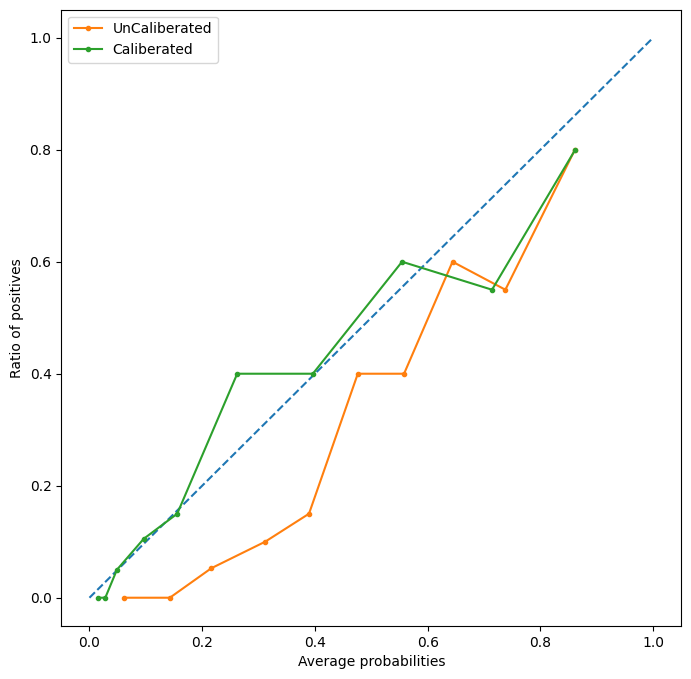

In [92]:
fig = pyplot.figure(1, figsize=(8, 8))
y, x = calibration_curve(y_test, pred_test/1000.0,
                         strategy='quantile', n_bins=10)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(x, y, marker='.', label='UnCaliberated')
y, x = calibration_curve(y_test, cal_pred_test/1000.0,
                         strategy='quantile', n_bins=10)
pyplot.plot(x, y, marker='.', label='Caliberated')
pyplot.legend(loc='lower right')
pyplot.xlabel('Average probabilities')
pyplot.ylabel('Ratio of positives')
pyplot.legend(loc='upper left')

Model Performance

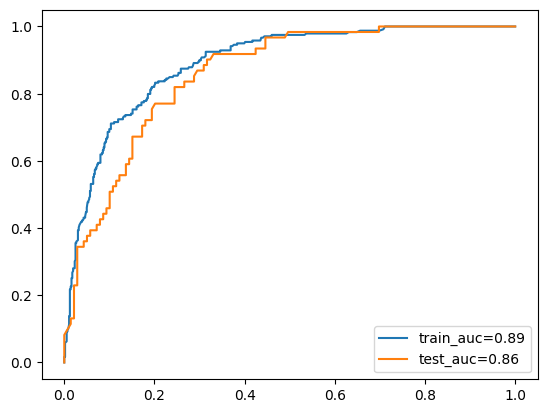

In [90]:
import matplotlib.pyplot as plt
fpr, tpr, roc_thresholds = roc_curve(y_train, cal_pred_train)
train_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"train_auc={str(np.around(train_auc, decimals=2))}")
fpr, tpr, roc_thresholds = roc_curve(y_test, cal_pred_test)
test_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"test_auc={str(np.around(test_auc, decimals=2))}")
plt.legend(loc=4)
plt.show()

In [99]:
with open("./artefacts/cal_model.pkl", 'wb') as f:
    pickle.dump(cal_model, f, pickle.HIGHEST_PROTOCOL)


Thresholding

In [116]:
model_decisions_test = pd.DataFrame(y_test)
model_decisions_test['loan_default_rating_raw'] = cal_pred_test
model_decisions_test['weights'] = 1.0
model_decisions_test.shape

(200, 3)

In [129]:
def calc_prec_recall_gt_threshold(risk_df, threshold):
  tp = risk_df[(risk_df.loan_default_rating_raw >= threshold) & (risk_df.default==1)]['weights'].sum()
  fn = risk_df[(risk_df.loan_default_rating_raw < threshold) & (risk_df.default==1)]['weights'].sum()
  fp = risk_df[(risk_df.loan_default_rating_raw >= threshold) & (risk_df.default==0)]['weights'].sum()
  return (round(tp * 100.0 / (tp + fp + np.finfo(float).eps), 3),
          round(tp * 100.0 / (tp + fn + np.finfo(float).eps), 3),
          round(risk_df[(risk_df.loan_default_rating_raw >= threshold)]['weights'].sum() * 100.0 / (risk_df['weights'].sum() + np.finfo(float).eps), 3))

def calc_prec_recall_lt_threshold(risk_df, threshold):
  tp = risk_df[(risk_df.loan_default_rating_raw < threshold) & (risk_df.default==1)]['weights'].sum()
  fn = risk_df[(risk_df.loan_default_rating_raw >= threshold) & (risk_df.default==1)]['weights'].sum()
  fp = risk_df[(risk_df.loan_default_rating_raw < threshold) & (risk_df.default==0)]['weights'].sum()
  return (round(tp * 100.0 / (tp + fp + np.finfo(float).eps), 3),
          round(tp * 100.0 / (tp + fn + np.finfo(float).eps), 3),
          round(risk_df[(risk_df.loan_default_rating_raw < threshold)]['weights'].sum() * 100.0 / (risk_df['weights'].sum() + np.finfo(float).eps), 3))

In [130]:
def cal_thresholds(model_decisions_df: pd.DataFrame,
                   reject_min_precision: float,
                   reject_max_recall: float,
                   reject_max_group_size: float,
                   approved_max_precision: float,
                   approved_max_recall: float,
                   approved_max_group_size: float) -> dict:

  thresholds = {}

  # Calculate mkyc->reject threshold
  high_risk_threshold = model_decisions_df.loan_default_rating_raw.max()
  step_size = 1
  while True:
    precision, recall, group_size = calc_prec_recall_gt_threshold(model_decisions_df, high_risk_threshold)
    if precision >= reject_min_precision and recall <= reject_max_recall and group_size <= reject_max_group_size:
      high_risk_threshold -= step_size
      continue
    else:
      break
  thresholds["mkyc -> reject"] = {"threshold": high_risk_threshold, "Precision": precision, "Recall": recall, "group_size": group_size}

  # Calculate approved->mkyc risk threshold
  low_risk_threshold = model_decisions_df.loan_default_rating_raw.min()
  step_size = 1
  while True:
    precision, recall, group_size = calc_prec_recall_lt_threshold(model_decisions_df, low_risk_threshold)
    if precision <= approved_max_precision and recall <= approved_max_recall and group_size <= approved_max_group_size:
      low_risk_threshold += step_size
      continue
    else:
      break
  thresholds["approved -> mkyc"] = {"threshold": low_risk_threshold, "Precision": precision, "Recall": recall, "group_size": group_size}

  return thresholds


In [131]:
print("# Loan Default Thresholds\n")
thresholds = cal_thresholds(model_decisions_test,
               95, 35, 15, # mkyc->prohibted parameters
               10, 15, 5 # approve -> mkyc parameters
              )
thresholds

# Loan Default Thresholds



{'mkyc -> reject': {'threshold': 878.0,
  'Precision': 85.714,
  'Recall': 9.836,
  'group_size': 3.5},
 'approved -> mkyc': {'threshold': 16.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'group_size': 6.0}}

In [163]:
with open("./artefacts/thresholds.pkl", 'wb') as f:
    pickle.dump(thresholds, f, pickle.HIGHEST_PROTOCOL)

In [134]:
mkyc_reject_threshold, approved_mkyc_threshold = thresholds.get("mkyc -> reject").get("threshold"), thresholds.get("approved -> mkyc").get("threshold")
print(mkyc_reject_threshold, approved_mkyc_threshold)

878.0 16.0


Explainability using Shap

In [93]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_encoded)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [94]:
corr_df = pd.DataFrame(shap_values.values, columns=varlist).corr('spearman')
corr_df

,checking_balance,months_loan_duration,amount,savings_balance,employment_length_months,residence_history_months,installment_rate,age,existing_credits,dependents,credit_history,purpose,personal_status,other_debtors,property,installment_plan,housing,foreign_worker,job
checking_balance,1.000000,-0.005486,0.034921,0.246597,0.093857,-0.017659,-0.082230,0.082875,-0.114827,0.167071,0.173521,0.044785,0.080658,0.098017,0.020877,0.523950,0.096925,0.000102,0.220900
months_loan_duration,-0.005486,1.000000,0.200674,-0.060474,0.061556,-0.123476,-0.015521,0.022498,-0.040970,-0.047067,0.125965,-0.004189,-0.110436,0.369249,0.282224,0.134666,0.214907,0.115832,-0.134760
amount,0.034921,0.200674,1.000000,0.074806,-0.050526,-0.140948,-0.081978,-0.067331,0.190450,0.111758,0.001792,0.033475,-0.006408,0.058980,0.169414,0.088436,0.319720,0.121884,-0.110522
savings_balance,0.246597,-0.060474,0.074806,1.000000,0.090017,-0.043891,-0.012449,0.159252,0.088383,0.168694,-0.047178,0.103251,0.058471,0.338808,0.097998,0.237191,0.137119,0.025310,0.018951
employment_length_months,0.093857,0.061556,-0.050526,0.090017,1.000000,-0.080776,-0.090619,0.085525,0.101107,0.137156,-0.074546,0.018820,0.223435,0.149008,0.066809,0.066468,-0.037451,0.084811,-0.187615
residence_history_months,-0.017659,-0.123476,-0.140948,-0.043891,-0.080776,1.000000,0.010221,0.086498,-0.030476,0.091831,0.063444,0.028653,0.010433,-0.127524,0.012771,-0.003222,-0.190560,0.156478,-0.047861
installment_rate,-0.082230,-0.015521,-0.081978,-0.012449,-0.090619,0.010221,1.000000,-0.130806,-0.117204,-0.020382,0.143592,0.011860,-0.040518,-0.063301,0.060041,-0.098915,-0.070267,-0.093224,0.041094
age,0.082875,0.022498,-0.067331,0.159252,0.085525,0.086498,-0.130806,1.000000,-0.089581,0.326139,0.099347,-0.069125,0.095056,0.063205,-0.070751,0.188519,0.024514,0.058149,0.021994
existing_credits,-0.114827,-0.040970,0.190450,0.088383,0.101107,-0.030476,-0.117204,-0.089581,1.000000,0.093077,-0.399380,0.106138,0.034714,-0.022724,0.134909,-0.167957,0.091952,0.012861,0.093434
dependents,0.167071,-0.047067,0.111758,0.168694,0.137156,0.091831,-0.020382,0.326139,0.093077,1.000000,-0.071383,0.100340,0.160174,0.030859,-0.013896,0.109450,-0.062474,0.005165,0.187217


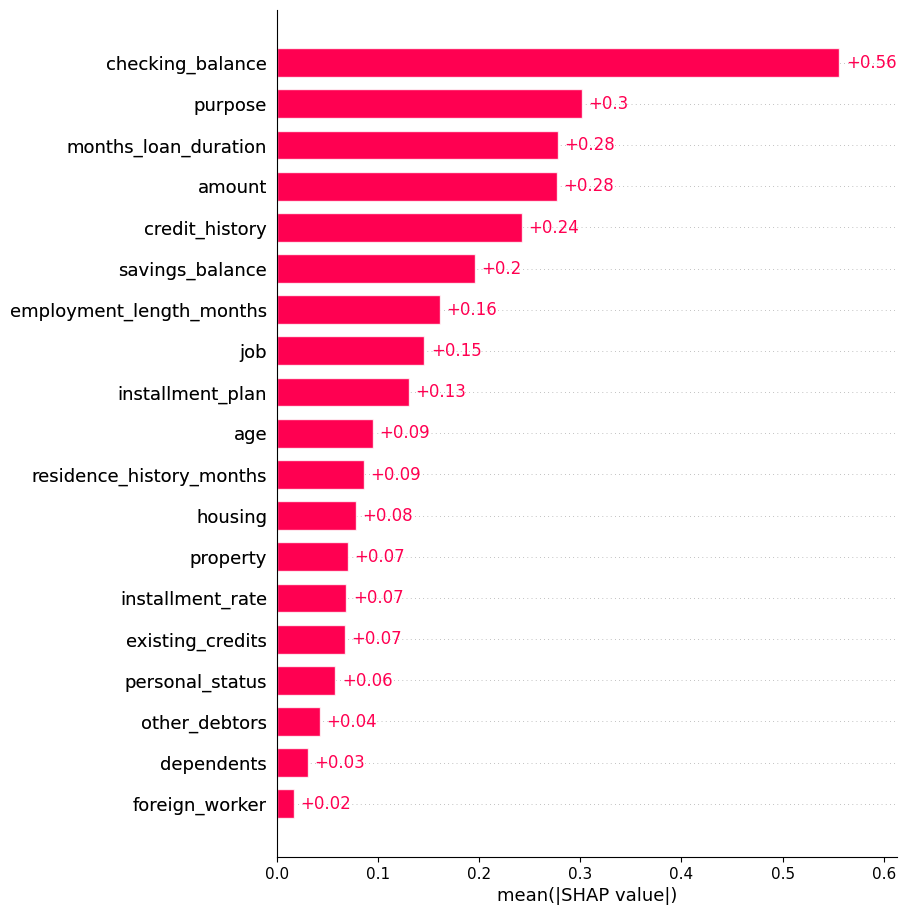

In [95]:
shap.plots.bar(shap_values, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


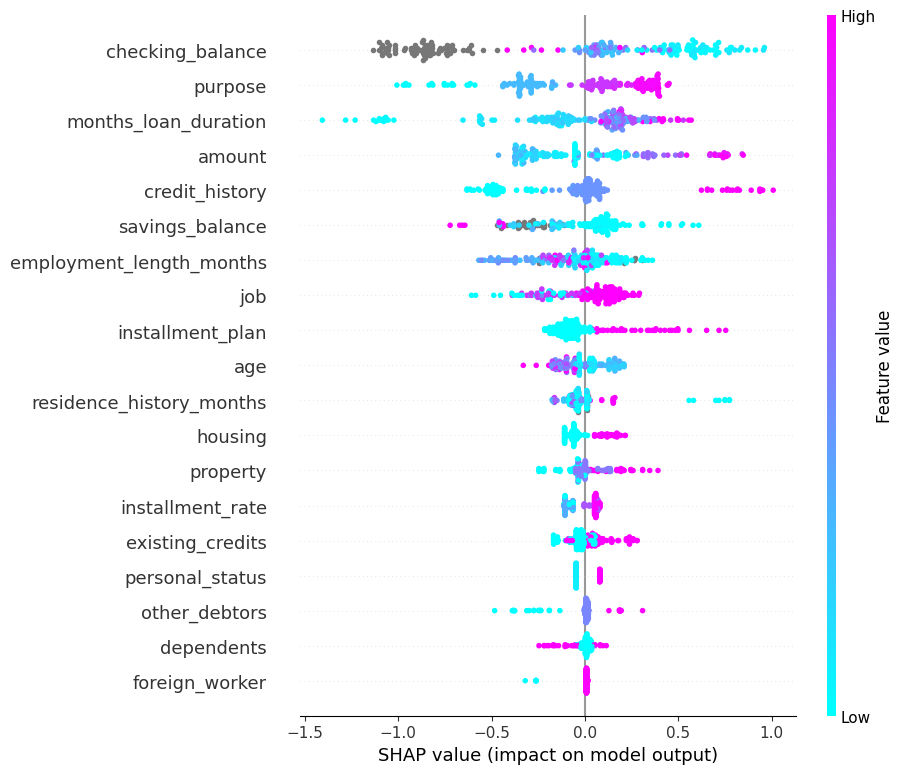

In [96]:
shap.plots.beeswarm(shap_values, max_display=20, color=plt.get_cmap("cool"))

In [100]:
with open("./artefacts/shap_explainer.pkl", 'wb') as f:
    pickle.dump(explainer, f, pickle.HIGHEST_PROTOCOL)

Engine

In [2]:
import json
with open("./data/credit_report_sample.json", 'r') as f:
    file = json.load(f)[0]
print(file)

{'application_id': 9711360, 'data': {'consumerfullcredit': {'subjectlist': {'reference': '128566', 'consumerid': '128566', 'searchoutput': 'XXX '}, 'accountrating': {'noofotheraccountsbad': '0', 'noofotheraccountsgood': '3', 'noofretailaccountsbad': '0', 'noofretailaccountsgood': '2', 'nooftelecomaccountsbad': '0', 'noofautoloanaccountsbad': '0', 'noofautoloanccountsgood': '0', 'noofhomeloanaccountsbad': '0', 'nooftelecomaccountsgood': '0', 'noofhomeloanaccountsgood': '0', 'noofjointloanaccountsbad': '0', 'noofstudyloanaccountsbad': '0', 'noofcreditcardaccountsbad': '0', 'noofjointloanaccountsgood': '0', 'noofstudyloanaccountsgood': '0', 'noofcreditcardaccountsgood': '1', 'noofpersonalloanaccountsbad': '0', 'noofpersonalloanaccountsgood': '1'}, 'enquirydetails': {'productid': '45', 'matchingrate': '90', 'subscriberenquiryengineid': '5012874225', 'subscriberenquiryresultid': '6381470'}, 'guarantorcount': {'accounts': '0', 'guarantorssecured': '0'}, 'guarantordetails': {'guarantorgender'

In [7]:
file.get("data").get("consumerfullcredit").keys()

dict_keys(['subjectlist', 'accountrating', 'enquirydetails', 'guarantorcount', 'guarantordetails', 'telephonehistory', 'employmenthistory', 'enquiryhistorytop', 'creditaccountsummary', 'deliquencyinformation', 'creditagreementsummary', 'personaldetailssummary', 'accountmonthlypaymenthistory', 'accountmonthlypaymenthistoryheader'])

In [14]:
file.get("data").get("consumerfullcredit").get("creditagreementsummary")

[{'currency': 'NGN',
  'accountno': '0324562636176001',
  'closeddate': '01/11/2020',
  'loanduration': '1170',
  'subaccountno': None,
  'accountstatus': 'Open',
  'amountoverdue': '22,441.39',
  'subscribername': 'First City Monument Bank Ltd Lagos',
  'lastupdateddate': '07/08/2020',
  'instalmentamount': '24,368.39',
  'currentbalanceamt': '82,733.58',
  'dateaccountopened': '15/01/2016',
  'openingbalanceamt': '814,700.00',
  'performancestatus': 'Performing',
  'repaymentfrequency': 'Monthly',
  'indicatordescription': 'Personal secured loan'},
 {'currency': 'NGN',
  'accountno': '0324602636176001',
  'closeddate': '30/11/2019',
  'loanduration': '59',
  'subaccountno': None,
  'accountstatus': 'Closed',
  'amountoverdue': '0.00',
  'subscribername': 'First City Monument Bank Ltd Lagos',
  'lastupdateddate': '08/08/2017',
  'instalmentamount': '17,036.09',
  'currentbalanceamt': '0.00',
  'dateaccountopened': '28/08/2014',
  'openingbalanceamt': '704,000.00',
  'performancestatus